In [45]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import os

# Time series analysis
In this analysis we aim to predict the `number of accidents` and the `severity of the accidents`.

## Setting up the dataset
It is our intention to create a "found" time series, that is a dataset which is properly cleaned and structured to work with state of the art time series analysis algorithms. The reason for this is that our original Kaggle dataset was not intended to be used for time series analysis and was therefore not organized as such.

In the following, we'll look at the main problems with this dataset, before outlining the strategy we've developed to address them.

### The problem of a messy dataset
The reader should bear in mind that the dataset used is a *government dataset*. As such, due to politics, budgets and other exogenous considerations, missing and inaccurate values, incomplete rows and discontinuities should be expected.

And that's not even the half of it. Given the nature of the dataset we should expect the *time discounting* phenomenom to hinder the accuracy of the recorded information. More specifically, as this is an accident-related dataset, the event is recorded after the intervention of a traffic officer and after a report has been written. This means that the timestamp of the registration is likely to be distant from the timestamp of the accident, and details outside the report may be misreported, due to the *time discounting* phenomenom.

### The problem of daylight savings time
<p align="center">
    <img src="img/time_zone.png" width="60%"/>
</p>

As the dataset is based on accidents that took place in the United Kingdom, the problem of time zone mismatch does not arise. In fact, the whole country is in the UTC time zone, so not only do we not have to worry about multiple time zones based on latitude and longitude values, but also we have equivalence between UTC and the local time zone.

However, there's still the problem of daylight savings time, which causes some instants to occur twice a year and others to not exist at all.

<!-- 
- time discounting, huge dataset => downsample with aggregation, timestamp should prevent lookahead
- daylight savings => needs investigation, however we don't care due to the aggregation
- utc (photo), fortunatly
- null values?
-->

In [2]:
DATASET_NAME='Accident_Information.csv'

In [3]:
df_original = pd.read_csv(os.path.join('../dataset', DATASET_NAME), low_memory=False)

In [78]:
df = (
    df_original[['Accident_Severity', 'Date', 'Time']]
    .assign(timestamp=pd.to_datetime(df_original['Date'] + ' ' + df_original['Time']))
    .drop(columns=['Date', 'Time'])
)

In [79]:
f'Original size = {df_original.size/1024 **
                   2:.2f} MB', f'Pruned size = {df.size/1024**2:.2f} MB'

('Original size = 66.38 MB', 'Pruned size = 3.90 MB')

In [80]:
print(f'{len(df[df.isnull().any(axis=1)])
         } rows have a null value, so I remove them')
df = df.dropna()

156 rows have a null value, so I remove them


In [82]:
df.describe()

,timestamp
count,2047100
mean,2011-01-13 08:48:15.167358720
min,2005-01-01 00:01:00
25%,2007-09-08 20:11:45
50%,2010-10-10 00:06:30
75%,2014-04-18 10:04:15
max,2017-12-31 23:31:00


/tmp/ipykernel_44503/1712328572.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=value_counts.index, y=value_counts.values, palette='Blues_r')
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


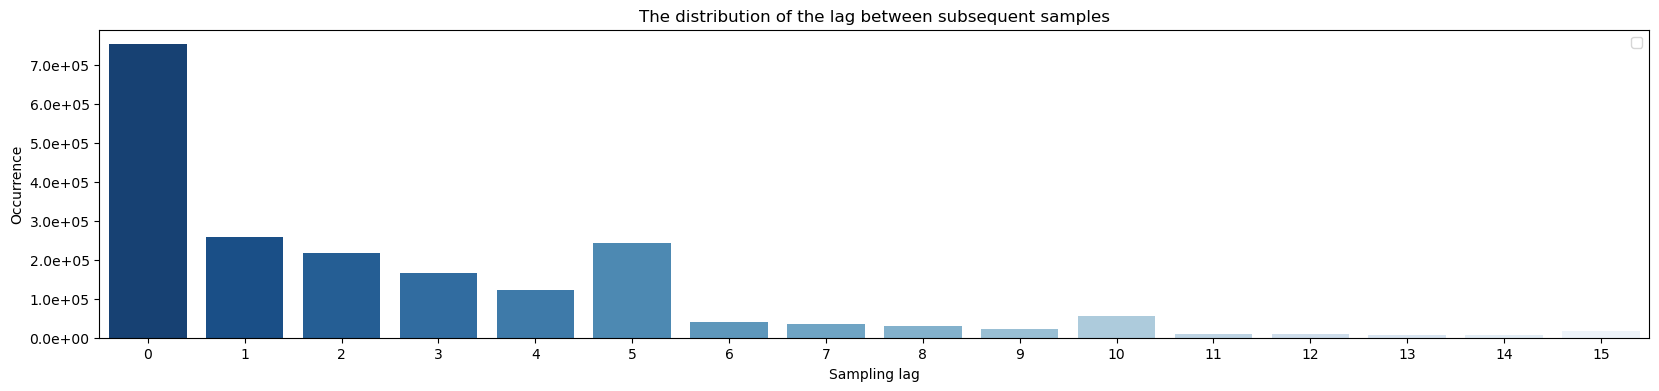

In [76]:
df = df.sort_values(by='timestamp')
df['step'] = (df['timestamp'].diff().dt.total_seconds() / 60).fillna(0)
value_counts = df[df['step'] <= 15]['step'].value_counts().sort_index()

plt.figure(figsize=(20, 4))
sns.barplot(x=value_counts.index, y=value_counts.values, palette='Blues_r')
plt.gca().xaxis.set_major_formatter(FuncFormatter(lambda x, _: f'{int(x)}'))
plt.gca().yaxis.set_major_formatter(FuncFormatter(lambda y, _: f'{y:.1e}'))
plt.title('The distribution of the lag between subsequent samples')
plt.xlabel('Sampling lag')
plt.ylabel('Occurrence')
plt.legend()
plt.show()

In [77]:
len(df[df['step']==0])/len(df)*100

36.75187665831728

Here a new problem arises, a large proportion of the events (36.75%) are less than 1 minute apart in different locations in the UK, whereas the granularity of the recording is 1 minute. This means that these events collapse into a single point in time.

## Exploratory analysis

<!-- 
- plot of 12 TS 1 for each year, and then 1 for each month
- stagionality is additive or multiplicative? Should plot the residuals from the mean
- stationarity, Aug Dickey Fuller (and KPSS?)
- BoxCox
-->